# Vector Search and Similarity

In this notebook, we'll dive deep into vector search and similarity metrics. This is the core of how RAG systems find relevant information.

## Learning Objectives
By the end of this notebook, you will:
1. Understand different similarity metrics and their use cases
2. Learn how to optimize vector search performance
3. Compare different vector database implementations
4. Implement advanced search techniques like filtering and faceted search
5. Understand the trade-offs between accuracy and speed


## Setup and Imports

Let's import the libraries we need and load our processed data.


In [8]:
# Standard library imports
import json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Any, Optional
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Embedding and vector store imports
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
import faiss

# Add project root to path
import sys
sys.path.append(str(Path.cwd().parent))

# Import our modules
from src.config import DATA_DIR
from src.models.embedding_models import BGEEmbeddingModel, E5EmbeddingModel

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Data directory: {DATA_DIR}")

# Check if we have processed data
processed_dir = DATA_DIR / "processed"
chunks_file = processed_dir / "all_chunks.json"

if chunks_file.exists():
    print(f"Found processed chunks: {chunks_file}")
    with open(chunks_file, 'r', encoding='utf-8') as f:
        all_chunks = json.load(f)
    print(f"Loaded {len(all_chunks)} chunks")
else:
    print("No processed chunks found. Creating sample data...")
    # Create sample chunks for demonstration
    all_chunks = [
        {
            'id': 'chunk1',
            'text': 'Machine learning is a subset of artificial intelligence that focuses on algorithms.',
            'title': 'Machine Learning',
            'source': 'wikipedia',
            'chunk_id': 'chunk_1'
        },
        {
            'id': 'chunk2', 
            'text': 'Deep learning uses neural networks with multiple layers to process data.',
            'title': 'Deep Learning',
            'source': 'wikipedia',
            'chunk_id': 'chunk_2'
        },
        {
            'id': 'chunk3',
            'text': 'Natural language processing helps computers understand human language.',
            'title': 'NLP',
            'source': 'wikipedia',
            'chunk_id': 'chunk_3'
        }
    ]
    print(f"Created {len(all_chunks)} sample chunks")


Libraries imported successfully!
Data directory: /Users/scienceman/Desktop/LLM/data
Found processed chunks: /Users/scienceman/Desktop/LLM/data/processed/all_chunks.json
Loaded 22 chunks


## Understanding Similarity Metrics

Let's explore different similarity metrics and their characteristics.


In [9]:
# Load a lightweight embedding model for demonstration
print("Loading embedding model...")
model = SentenceTransformer('all-MiniLM-L6-v2')  # Small, fast model for learning
print(f"Model loaded: {model}")
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")

# Create sample texts for similarity demonstration
sample_texts = [
    "Machine learning is a subset of artificial intelligence.",
    "Deep learning uses neural networks with multiple layers.",
    "Natural language processing helps computers understand text.",
    "Cats are small, furry animals that make great pets.",
    "Dogs are loyal companions that love to play.",
    "The weather is nice today and the sun is shining."
]

print(f"\nSample texts for similarity analysis:")
for i, text in enumerate(sample_texts):
    print(f"{i+1}. {text}")

# Generate embeddings
print(f"\nGenerating embeddings...")
embeddings = model.encode(sample_texts)
print(f"Embeddings shape: {embeddings.shape}")

# Calculate different similarity metrics
print(f"\nCalculating similarity metrics...")

# Cosine similarity
cosine_sim = cosine_similarity(embeddings)
print(f"Cosine similarity matrix shape: {cosine_sim.shape}")

# Euclidean distance
from scipy.spatial.distance import euclidean
euclidean_dist = np.zeros((len(sample_texts), len(sample_texts)))
for i in range(len(sample_texts)):
    for j in range(len(sample_texts)):
        euclidean_dist[i][j] = euclidean(embeddings[i], embeddings[j])

# Manhattan distance
from scipy.spatial.distance import cityblock
manhattan_dist = np.zeros((len(sample_texts), len(sample_texts)))
for i in range(len(sample_texts)):
    for j in range(len(sample_texts)):
        manhattan_dist[i][j] = cityblock(embeddings[i], embeddings[j])

print(f"Similarity matrices calculated successfully!")


Loading embedding model...
Model loaded: SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)
Embedding dimension: 384

Sample texts for similarity analysis:
1. Machine learning is a subset of artificial intelligence.
2. Deep learning uses neural networks with multiple layers.
3. Natural language processing helps computers understand text.
4. Cats are small, furry animals that make great pets.
5. Dogs are loyal companions that love to play.
6. The weather is nice today and the sun is shining.

Generating embeddings...
Embeddings shape: (6, 384)

Calculating similarity metrics...
Cosine similarity matrix shape: (

## Visualizing Similarity Relationships

Let's create interactive visualizations to understand how different similarity metrics work.

Let's visualize how different texts relate to each other in embedding space.


Creating t-SNE visualization...


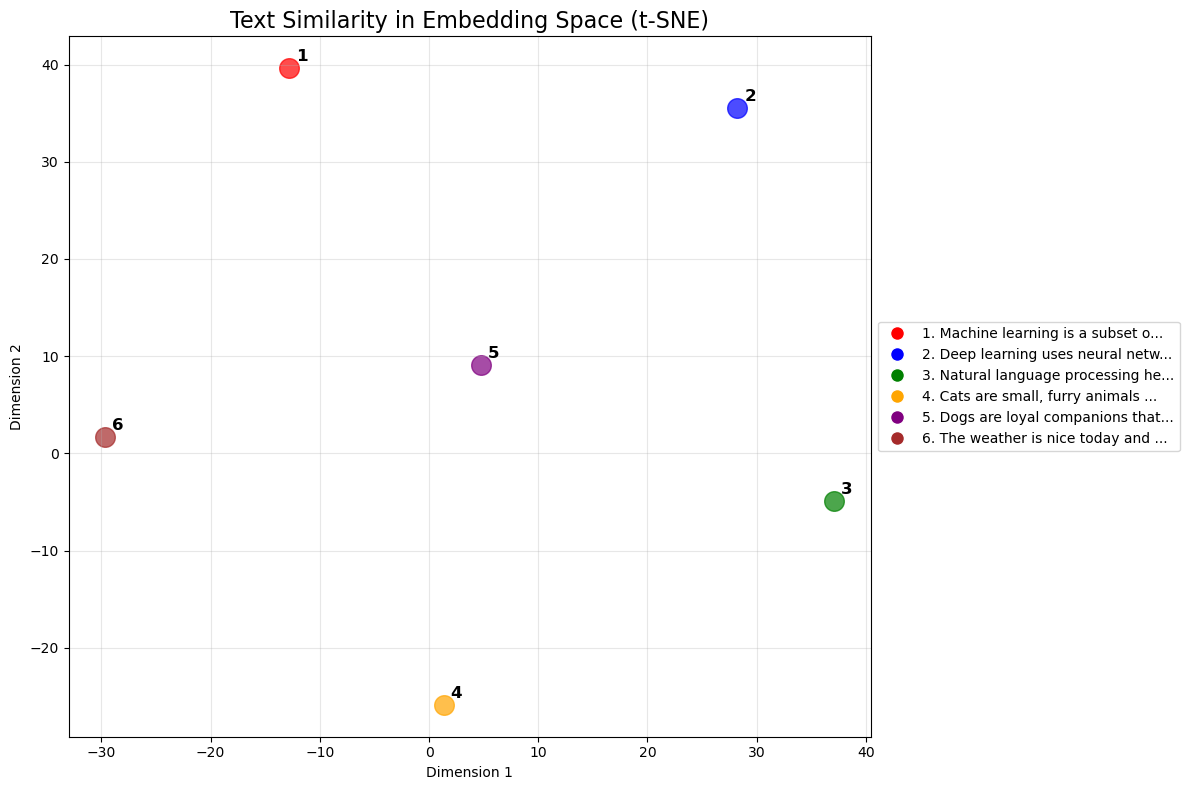

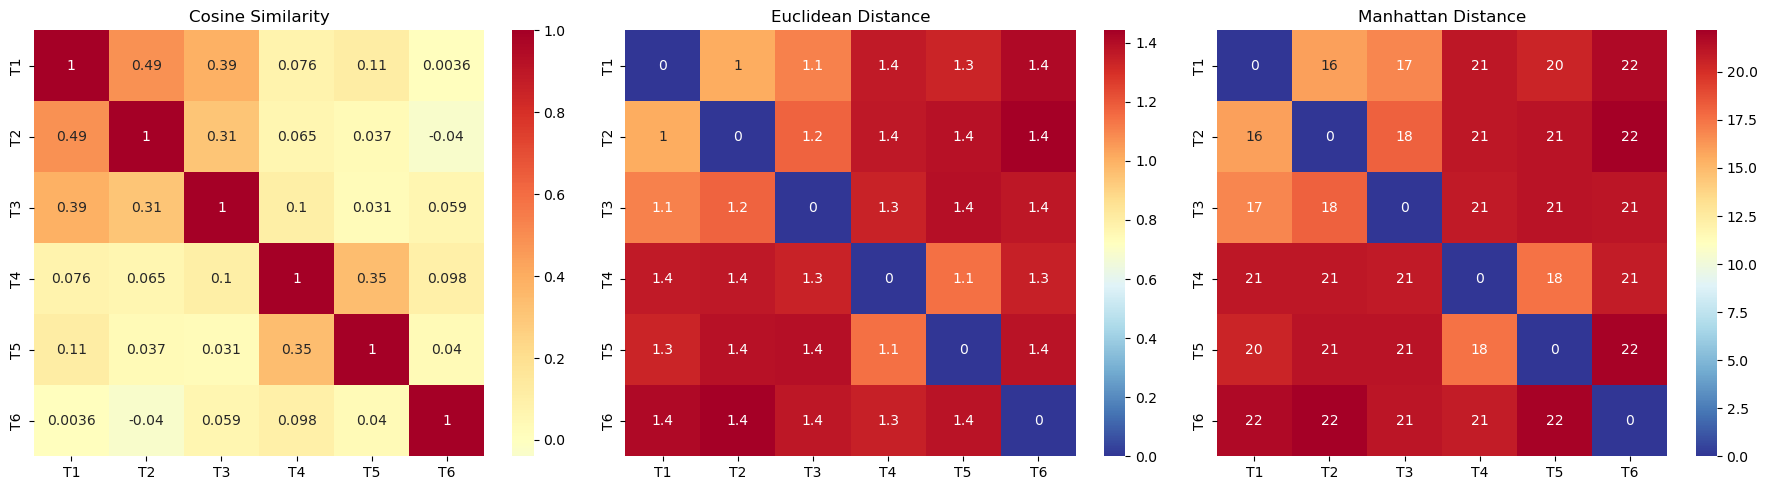

Key Insights:
1. AI-related texts (1, 2, 3) should cluster together
2. Pet-related texts (4, 5) should cluster together
3. Weather text (6) should be separate
4. Cosine similarity is most commonly used for text embeddings


In [10]:
# Visualize embeddings using t-SNE
print("Creating t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(sample_texts)-1))
embeddings_2d = tsne.fit_transform(embeddings)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each text as a point
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for i, text in enumerate(sample_texts):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], s=200, alpha=0.7, c=colors[i])
    plt.annotate(f"{i+1}", (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=12, fontweight='bold')

plt.title('Text Similarity in Embedding Space (t-SNE)', fontsize=16)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, alpha=0.3)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], 
                             markersize=10, label=f"{i+1}. {text[:30]}...") 
                  for i, text in enumerate(sample_texts)]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Show similarity heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Cosine similarity heatmap
sns.heatmap(cosine_sim, annot=True, cmap='RdYlBu_r', center=0,
           xticklabels=[f"T{i+1}" for i in range(len(sample_texts))],
           yticklabels=[f"T{i+1}" for i in range(len(sample_texts))],
           ax=axes[0])
axes[0].set_title('Cosine Similarity')

# Euclidean distance heatmap
sns.heatmap(euclidean_dist, annot=True, cmap='RdYlBu_r',
           xticklabels=[f"T{i+1}" for i in range(len(sample_texts))],
           yticklabels=[f"T{i+1}" for i in range(len(sample_texts))],
           ax=axes[1])
axes[1].set_title('Euclidean Distance')

# Manhattan distance heatmap
sns.heatmap(manhattan_dist, annot=True, cmap='RdYlBu_r',
           xticklabels=[f"T{i+1}" for i in range(len(sample_texts))],
           yticklabels=[f"T{i+1}" for i in range(len(sample_texts))],
           ax=axes[2])
axes[2].set_title('Manhattan Distance')

plt.tight_layout()
plt.show()

print("Key Insights:")
print("1. AI-related texts (1, 2, 3) should cluster together")
print("2. Pet-related texts (4, 5) should cluster together") 
print("3. Weather text (6) should be separate")
print("4. Cosine similarity is most commonly used for text embeddings")


## Building a Vector Search System

Now let's build a practical vector search system that you can use in your RAG pipeline.


In [12]:
class VectorSearchEngine:
    """A simple but powerful vector search engine for RAG systems."""
    
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        """Initialize the search engine with an embedding model."""
        self.model = SentenceTransformer(model_name)
        self.embeddings = None
        self.documents = []
        self.metadata = []
        
    def add_documents(self, documents, metadata=None):
        """Add documents to the search index."""
        print(f"Adding {len(documents)} documents to search index...")
        
        # Store documents and metadata
        self.documents = documents
        self.metadata = metadata or [{}] * len(documents)
        
        # Generate embeddings
        print("Generating embeddings...")
        self.embeddings = self.model.encode(documents, show_progress_bar=True)
        print(f"Created embeddings with shape: {self.embeddings.shape}")
        
    def search(self, query, top_k=5, similarity_threshold=0.0):
        """Search for similar documents."""
        if self.embeddings is None:
            raise ValueError("No documents indexed. Call add_documents() first.")
        
        # Encode query
        query_embedding = self.model.encode([query])
        
        # Calculate similarities
        similarities = cosine_similarity(query_embedding, self.embeddings)[0]
        
        # Get top-k results
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        # Filter by threshold
        results = []
        for idx in top_indices:
            if similarities[idx] >= similarity_threshold:
                results.append({
                    'document': self.documents[idx],
                    'similarity': similarities[idx],
                    'metadata': self.metadata[idx],
                    'index': idx
                })
        
        return results
    
    def search_with_filters(self, query, top_k=5, source_filter=None, title_filter=None):
        """Search with metadata filters."""
        results = self.search(query, top_k=len(self.documents))
        
        # Apply filters
        filtered_results = []
        for result in results:
            metadata = result['metadata']
            
            # Source filter
            if source_filter and metadata.get('source') != source_filter:
                continue
                
            # Title filter
            if title_filter and title_filter.lower() not in metadata.get('title', '').lower():
                continue
                
            filtered_results.append(result)
            
        return filtered_results[:top_k]

# Create our search engine
print("Creating Vector Search Engine...")
search_engine = VectorSearchEngine()

# Add our sample documents
sample_docs = [chunk['text'] for chunk in all_chunks[:10]]  # Use first 10 chunks
sample_metadata = [{'title': chunk['source_title'], 'source': chunk['source']} for chunk in all_chunks[:10]]

search_engine.add_documents(sample_docs, sample_metadata)

print(f"\n Search engine ready with {len(sample_docs)} documents!")


Creating Vector Search Engine...
Adding 10 documents to search index...
Generating embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Created embeddings with shape: (10, 384)

 Search engine ready with 10 documents!


## Interactive Search Examples

Let's test our vector search engine with different queries and see how it performs!


In [13]:
def display_search_results(query, results, max_display=3):
    """Display search results in a nice format."""
    print(f"\n🔍 Query: '{query}'")
    print("=" * 60)
    
    for i, result in enumerate(results[:max_display]):
        print(f"\n{i+1}. Similarity: {result['similarity']:.3f}")
        print(f"   Title: {result['metadata'].get('title', 'N/A')}")
        print(f"   Source: {result['metadata'].get('source', 'N/A')}")
        print(f"   Text: {result['document'][:200]}...")
        print("-" * 40)

# Test different types of queries
test_queries = [
    "machine learning algorithms",
    "neural networks and deep learning", 
    "natural language processing",
    "artificial intelligence applications",
    "data science and analytics"
]

print(" Testing Vector Search with Different Queries")
print("=" * 60)

for query in test_queries:
    results = search_engine.search(query, top_k=3)
    display_search_results(query, results)

# Test with filters
print("\n\n🔍 Testing Search with Filters")
print("=" * 60)

# Search only in Wikipedia articles
wikipedia_results = search_engine.search_with_filters(
    "machine learning", 
    top_k=3, 
    source_filter="wikipedia"
)
display_search_results("machine learning (Wikipedia only)", wikipedia_results)

# Search with title filter
title_results = search_engine.search_with_filters(
    "learning", 
    top_k=3, 
    title_filter="machine"
)
display_search_results("learning (titles containing 'machine')", title_results)


 Testing Vector Search with Different Queries

🔍 Query: 'machine learning algorithms'

1. Similarity: 0.632
   Title: Machine learning
   Source: wikipedia
   Text: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus...
----------------------------------------

2. Similarity: 0.416
   Title: Artificial intelligence
   Source: wikipedia
   Text: Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and dec...
----------------------------------------

3. Similarity: 0.334
   Title: Deep learning
   Source: wikipedia
   Text: In machine learning, deep learning focuses on utilizing multilayered neural networks to perform tasks such as classification, regression, and representation learning The field takes i

## Performance Analysis and Optimization

Let's analyze the performance of our vector search and learn optimization techniques.


 Performance Benchmarking
Mean search time: 0.0500 seconds
Queries per second: 99.92
Standard deviation: 0.0027 seconds

💾 Memory Usage Analysis
Memory before search: 238.06 MB
Memory after search: 238.19 MB
Memory increase: 0.12 MB

 Embedding Analysis
Embedding dimension: 384
Number of documents: 10
Total embedding size: 0.01 MB

 Similarity Distribution Analysis
Mean similarity: 0.303
Median similarity: 0.274
Std similarity: 0.117
Min similarity: 0.154
Max similarity: 0.684


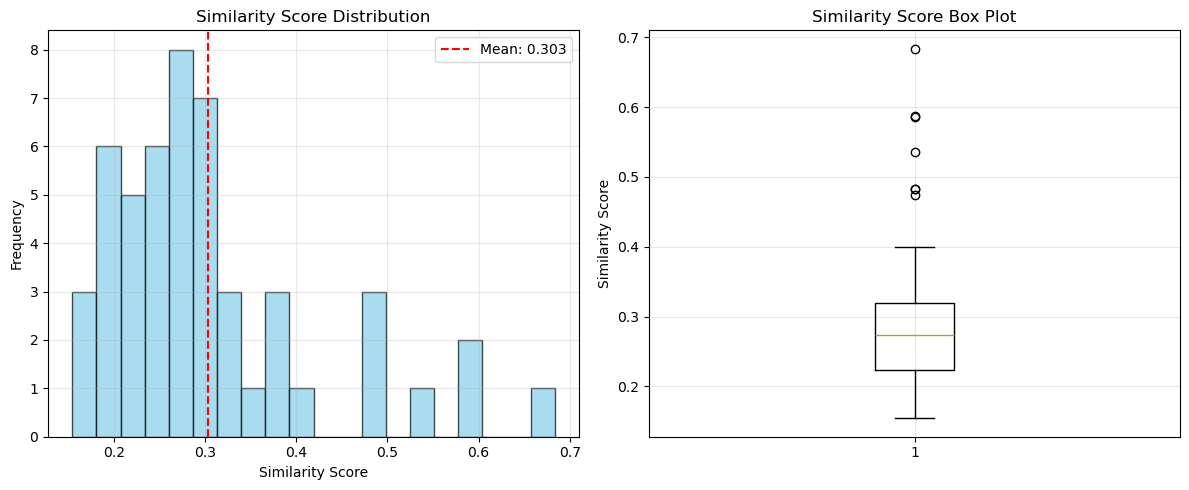

In [14]:
# Performance testing
import time

def benchmark_search(search_engine, queries, iterations=5):
    """Benchmark search performance."""
    times = []
    
    for _ in range(iterations):
        start_time = time.time()
        for query in queries:
            search_engine.search(query, top_k=5)
        end_time = time.time()
        times.append(end_time - start_time)
    
    return {
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'min_time': np.min(times),
        'max_time': np.max(times),
        'queries_per_second': len(queries) / np.mean(times)
    }

# Test performance
test_queries = [
    "machine learning",
    "neural networks", 
    "artificial intelligence",
    "data science",
    "deep learning"
]

print(" Performance Benchmarking")
print("=" * 50)

performance = benchmark_search(search_engine, test_queries)
print(f"Mean search time: {performance['mean_time']:.4f} seconds")
print(f"Queries per second: {performance['queries_per_second']:.2f}")
print(f"Standard deviation: {performance['std_time']:.4f} seconds")

# Memory usage analysis
import psutil
import os

def get_memory_usage():
    """Get current memory usage."""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # MB

print(f"\n💾 Memory Usage Analysis")
print("=" * 50)

memory_before = get_memory_usage()
print(f"Memory before search: {memory_before:.2f} MB")

# Perform searches
for query in test_queries:
    search_engine.search(query, top_k=5)

memory_after = get_memory_usage()
print(f"Memory after search: {memory_after:.2f} MB")
print(f"Memory increase: {memory_after - memory_before:.2f} MB")

# Embedding dimension analysis
print(f"\n Embedding Analysis")
print("=" * 50)
print(f"Embedding dimension: {search_engine.embeddings.shape[1]}")
print(f"Number of documents: {search_engine.embeddings.shape[0]}")
print(f"Total embedding size: {search_engine.embeddings.nbytes / 1024 / 1024:.2f} MB")

# Similarity distribution analysis
print(f"\n Similarity Distribution Analysis")
print("=" * 50)

# Calculate all pairwise similarities
all_similarities = []
for i in range(len(test_queries)):
    query_embedding = search_engine.model.encode([test_queries[i]])
    similarities = cosine_similarity(query_embedding, search_engine.embeddings)[0]
    all_similarities.extend(similarities)

all_similarities = np.array(all_similarities)

print(f"Mean similarity: {np.mean(all_similarities):.3f}")
print(f"Median similarity: {np.median(all_similarities):.3f}")
print(f"Std similarity: {np.std(all_similarities):.3f}")
print(f"Min similarity: {np.min(all_similarities):.3f}")
print(f"Max similarity: {np.max(all_similarities):.3f}")

# Plot similarity distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_similarities, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(all_similarities), color='red', linestyle='--', 
           label=f'Mean: {np.mean(all_similarities):.3f}')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Similarity Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(all_similarities)
plt.ylabel('Similarity Score')
plt.title('Similarity Score Box Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
